# Test Unfold 2
 Test program as an example for a user specific regularisation scheme.

 1. Generate Monte Carlo and Data events
     The events consist of:
      - signal
      - background

     The signal is a resonance. It is generated with a Breit-Wigner,
     smeared by a Gaussian

 2. Unfold the data. The result is:
    - The background level
    - The shape of the resonance, corrected for detector effects

     The regularisation is done on the curvature, excluding the bins
     near the peak.

 3. produce some plots


 **Version 17.6, in parallel to changes in TUnfold**

#### History:
 - Version 17.5, in parallel to changes in TUnfold
 - Version 17.4, in parallel to changes in TUnfold
 - Version 17.3, in parallel to changes in TUnfold
 - Version 17.2, in parallel to changes in TUnfold
 - Version 17.1, in parallel to changes in TUnfold
 - Version 17.0, updated for changed methods in TUnfold
 - Version 16.1, parallel to changes in TUnfold
 - Version 16.0, parallel to changes in TUnfold
 - Version 15, with automatic L-curve scan, simplified example
 - Version 14, with changes in TUnfoldSys.cxx
 - Version 13,  with changes to TUnfold.C
 - Version 12,  with improvements to TUnfold.cxx
 - Version 11,  print chi**2 and number of degrees of freedom
 - Version 10, with bug-fix in TUnfold.cxx
 - Version 9, with bug-fix in TUnfold.cxx, TUnfold.h
 - Version 8, with bug-fix in TUnfold.cxx, TUnfold.h
 - Version 7, with bug-fix in TUnfold.cxx, TUnfold.h
 - Version 6a, fix problem with dynamic array allocation under windows
 - Version 6, re-include class MyUnfold in the example
 - Version 5, move class MyUnfold to separate files
 - Version 4, with bug-fix in TUnfold.C
 - Version 3, with bug-fix in TUnfold.C
 - Version 2, with changed ScanLcurve() arguments
 - Version 1, remove L curve analysis, use ScanLcurve() method instead
 - Version 0, L curve analysis included here

 This file is part of TUnfold.

 TUnfold is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 TUnfold is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.

 You should have received a copy of the GNU General Public License
 along with TUnfold.  If not, see <http://www.gnu.org/licenses/>.



**Author:** Stefan Schmitt DESY, 14.10.2008  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:58 AM.</small></i>

In [1]:
%%cpp -d
#include <TMath.h>
#include <TCanvas.h>
#include <TRandom3.h>
#include <TFitter.h>
#include <TF1.h>
#include <TStyle.h>
#include <TVector.h>
#include <TGraph.h>
#include "TUnfold.h"

using namespace std;


TRandom *rnd=0;

Generate an event

Negative mass: background event
  positive mass: signal event

In [2]:
Double_t GenerateEvent(Double_t bgr, // relative fraction of background
                       Double_t mass, // peak position
                       Double_t gamma) // peak width
{
  Double_t t;
  if(rnd->Rndm()>bgr) {
    // generate signal event
    // with positive mass
    do {
      do {
        t=rnd->Rndm();
      } while(t>=1.0);
      t=TMath::Tan((t-0.5)*TMath::Pi())*gamma+mass;
    } while(t<=0.0);
    return t;
  } else {
    // generate background event
    // generate events following a power-law distribution
    //   f(E) = K * TMath::power((E0+E),N0)
    static Double_t const E0=2.4;
    static Double_t const N0=2.9;
    do {
      do {
        t=rnd->Rndm();
      } while(t>=1.0);
      // the mass is returned negative
      // In our example a convenient way to indicate it is a background event.
      t= -(TMath::Power(1.-t,1./(1.-N0))-1.0)*E0;
    } while(t>=0.0);
    return t;
  }
}

  smear the event to detector level
 input:
   mass on generator level (mTrue>0 !)
 output:
   mass on detector level
 

In [3]:
%%cpp -d
Double_t DetectorEvent(Double_t mTrue) {
  // smear by double-gaussian
  static Double_t frac=0.1;
  static Double_t wideBias=0.03;
  static Double_t wideSigma=0.5;
  static Double_t smallBias=0.0;
  static Double_t smallSigma=0.1;
  if(rnd->Rndm()>frac) {
    return rnd->Gaus(mTrue+smallBias,smallSigma);
  } else {
    return rnd->Gaus(mTrue+wideBias,wideSigma);
  }
}

In [4]:
  // switch on histogram errors
  TH1::SetDefaultSumw2();

  // random generator
  rnd=new TRandom3();

  // data and MC luminosity, cross-section
  Double_t const luminosityData=100000;
  Double_t const luminosityMC=1000000;
  Double_t const crossSection=1.0;

  Int_t const nDet=250;
  Int_t const nGen=100;
  Double_t const xminDet=0.0;
  Double_t const xmaxDet=10.0;
  Double_t const xminGen=0.0;
  Double_t const xmaxGen=10.0;

  //============================================
  // generate MC distribution
  //
  TH1D *histMgenMC=new TH1D("MgenMC",";mass(gen)",nGen,xminGen,xmaxGen);
  TH1D *histMdetMC=new TH1D("MdetMC",";mass(det)",nDet,xminDet,xmaxDet);
  TH2D *histMdetGenMC=new TH2D("MdetgenMC",";mass(det);mass(gen)",nDet,xminDet,xmaxDet,
                           nGen,xminGen,xmaxGen);
  Int_t neventMC=rnd->Poisson(luminosityMC*crossSection);
  for(Int_t i=0;i<neventMC;i++) {
 Double_t mGen=GenerateEvent(0.3, // relative fraction of background
                             4.0, // peak position in MC
                             0.2); // peak width in MC
 Double_t mDet=DetectorEvent(TMath::Abs(mGen));
 // the generated mass is negative for background
 // and positive for signal
 // so it will be filled in the underflow bin
 // this is very convenient for the unfolding:
 // the unfolded result will contain the number of background
 // events in the underflow bin

 // generated MC distribution (for comparison only)
 histMgenMC->Fill(mGen,luminosityData/luminosityMC);
 // reconstructed MC distribution (for comparison only)
 histMdetMC->Fill(mDet,luminosityData/luminosityMC);

 // matrix describing how the generator input migrates to the
 // reconstructed level. Unfolding input.
 // NOTE on underflow/overflow bins:
 //  (1) the detector level under/overflow bins are used for
 //       normalisation ("efficiency" correction)
 //       in our toy example, these bins are populated from tails
 //       of the initial MC distribution.
 //  (2) the generator level underflow/overflow bins are
 //       unfolded. In this example:
 //       underflow bin: background events reconstructed in the detector
 //       overflow bin: signal events generated at masses > xmaxDet
 // for the unfolded result these bins will be filled
 //  -> the background normalisation will be contained in the underflow bin
 histMdetGenMC->Fill(mDet,mGen,luminosityData/luminosityMC);
  }

  //============================================
  // generate data distribution
  //
  TH1D *histMgenData=new TH1D("MgenData",";mass(gen)",nGen,xminGen,xmaxGen);
  TH1D *histMdetData=new TH1D("MdetData",";mass(det)",nDet,xminDet,xmaxDet);
  Int_t neventData=rnd->Poisson(luminosityData*crossSection);
  for(Int_t i=0;i<neventData;i++) {
 Double_t mGen=GenerateEvent(0.4, // relative fraction of background
                             3.8, // peak position
                             0.15); // peak width
 Double_t mDet=DetectorEvent(TMath::Abs(mGen));
 // generated data mass for comparison plots
 // for real data, we do not have this histogram
 histMgenData->Fill(mGen);

 // reconstructed mass, unfolding input
 histMdetData->Fill(mDet);
  }

  //=========================================================================
  // set up the unfolding
  TUnfold unfold(histMdetGenMC,TUnfold::kHistMapOutputVert,
              TUnfold::kRegModeNone);
  // regularisation
  //----------------
  // the regularisation is done on the curvature (2nd derivative) of
  // the output distribution
  //
  // One has to exclude the bins near the peak of the Breit-Wigner,
  // because there the curvature is high
  // (and the regularisation eventually could enforce a small
  //  curvature, thus biasing result)
  //
  // in real life, the parameters below would have to be optimized,
  // depending on the data peak position and width
  // Or maybe one finds a different regularisation scheme... this is
  // just an example...
  Double_t estimatedPeakPosition=3.8;
  Int_t nPeek=3;
  TUnfold::ERegMode regMode=TUnfold::kRegModeCurvature;
  // calculate bin number corresponding to estimated peak position
  Int_t iPeek=(Int_t)(nGen*(estimatedPeakPosition-xminGen)/(xmaxGen-xminGen)
                   // offset 1.5
                   // accounts for start bin 1
                   // and rounding errors +0.5
                   +1.5);
  // regularize output bins 1..iPeek-nPeek
  unfold.RegularizeBins(1,1,iPeek-nPeek,regMode);
  // regularize output bins iPeek+nPeek..nGen
  unfold.RegularizeBins(iPeek+nPeek,1,nGen-(iPeek+nPeek),regMode);

  // unfolding
  //-----------

  // set input distribution and bias scale (=0)
  if(unfold.SetInput(histMdetData,0.0)>=10000) {
 std::cout<<"Unfolding result may be wrong\n";
  }

  // do the unfolding here
  Double_t tauMin=0.0;
  Double_t tauMax=0.0;
  Int_t nScan=30;
  Int_t iBest;
  TSpline *logTauX,*logTauY;
  TGraph *lCurve;
  // this method scans the parameter tau and finds the kink in the L curve
  // finally, the unfolding is done for the "best" choice of tau
  iBest=unfold.ScanLcurve(nScan,tauMin,tauMax,&lCurve,&logTauX,&logTauY);
  std::cout<<"tau="<<unfold.GetTau()<<"\n";
  std::cout<<"chi**2="<<unfold.GetChi2A()<<"+"<<unfold.GetChi2L()
        <<" / "<<unfold.GetNdf()<<"\n";

  // save point corresponding to the kink in the L curve as TGraph
  Double_t t[1],x[1],y[1];
  logTauX->GetKnot(iBest,t[0],x[0]);
  logTauY->GetKnot(iBest,t[0],y[0]);
  TGraph *bestLcurve=new TGraph(1,x,y);
  TGraph *bestLogTauX=new TGraph(1,t,x);

  //============================================================
  // extract unfolding results into histograms

  // set up a bin map, excluding underflow and overflow bins
  // the binMap relates the the output of the unfolding to the final
  // histogram bins
  Int_t *binMap=new Int_t[nGen+2];
  for(Int_t i=1;i<=nGen;i++) binMap[i]=i;
  binMap[0]=-1;
  binMap[nGen+1]=-1;

  TH1D *histMunfold=new TH1D("Unfolded",";mass(gen)",nGen,xminGen,xmaxGen);
  unfold.GetOutput(histMunfold,binMap);
  TH1D *histMdetFold=new TH1D("FoldedBack","mass(det)",nDet,xminDet,xmaxDet);
  unfold.GetFoldedOutput(histMdetFold);

  // store global correlation coefficients
  TH1D *histRhoi=new TH1D("rho_I","mass",nGen,xminGen,xmaxGen);
  unfold.GetRhoI(histRhoi,binMap);

  delete[] binMap;
  binMap=0;

  //=====================================================================
  // plot some histograms
  TCanvas output;

  // produce some plots
  output.Divide(3,2);

  // Show the matrix which connects input and output
  // There are overflow bins at the bottom, not shown in the plot
  // These contain the background shape.
  // The overflow bins to the left and right contain
  // events which are not reconstructed. These are necessary for proper MC
  // normalisation
  output.cd(1);
  histMdetGenMC->Draw("BOX");

  // draw generator-level distribution:
  //   data (red) [for real data this is not available]
  //   MC input (black) [with completely wrong peak position and shape]
  //   unfolded data (blue)
  output.cd(2);
  histMunfold->SetLineColor(kBlue);
  histMunfold->Draw();
  histMgenData->SetLineColor(kRed);
  histMgenData->Draw("SAME");
  histMgenMC->Draw("SAME HIST");

  // show detector level distributions
  //    data (red)
  //    MC (black)
  //    unfolded data (blue)
  output.cd(3);
  histMdetFold->SetLineColor(kBlue);
  histMdetFold->Draw();
  histMdetData->SetLineColor(kRed);
  histMdetData->Draw("SAME");
  histMdetMC->Draw("SAME HIST");

  // show correlation coefficients
  //     all bins outside the peak are found to be highly correlated
  //     But they are compatible with zero anyway
  //     If the peak shape is fitted,
  //     these correlations have to be taken into account, see example
  output.cd(4);
  histRhoi->Draw();

  // show rhoi_max(tau) distribution
  output.cd(5);
  logTauX->Draw();
  bestLogTauX->SetMarkerColor(kRed);
  bestLogTauX->Draw("*");

  output.cd(6);
  lCurve->Draw("AL");
  bestLcurve->SetMarkerColor(kRed);
  bestLcurve->Draw("*");

  output.SaveAs("testUnfold2.ps");
  return 0;

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: 250 input bins and 102 output bins (includes 2 underflow/overflow bins)
Info in <TUnfold::ScanLcurve>: logtau=-Infinity X=2.186918 Y=8.913305
Info in <TUnfold::ScanLcurve>: logtau=-3.316953 X=2.218441 Y=7.452705
Info in <TUnfold::ScanLcurve>: logtau=-3.816953 X=2.197007 Y=8.159573
Info in <TUnfold::ScanLcurve>: logtau=-4.316953 X=2.187673 Y=8.747364
Info in <TUnfold::ScanLcurve>: logtau=-3.566953 X=2.205690 Y=7.815298
Info in <TUnfold::ScanLcurve>: logtau=-4.066953 X=2.190590 Y=8.508864
Info in <TUnfold::ScanLcurve>: logtau=-3.441953 X=2.211366 Y=7.640910
Info in <TUnfold::ScanLcurve>: logtau=-3.941953 X=2.193437 Y=8.340054
Info in <TUnfold::ScanLcurve>: logtau=-3.691953 X=2.201051 Y=7.984482
Info in <TUnfold::ScanLcurve>: logtau=-4.191953 X=2.188699 Y=8.647055
Info in <TUnfold::ScanLcurve>: logtau=-3.379453 X=2.214719 Y=7.548752
Info in <TUnfold::ScanLcurve>: logtau=-3.879453 X=2.195152 Y=8.249925
Info in <TUn

tau=0.000286365
chi**2=160.946+4.9728 / 147


Info in <TUnfold::ScanLcurve>: logtau=-4.035703 X=2.191216 Y=8.468939
Info in <TUnfold::ScanLcurve>: Result logtau=-3.543080 X=2.206680 Y=7.782760
Info in <TCanvas::Print>: ps file testUnfold2.ps has been created


Draw all canvases 

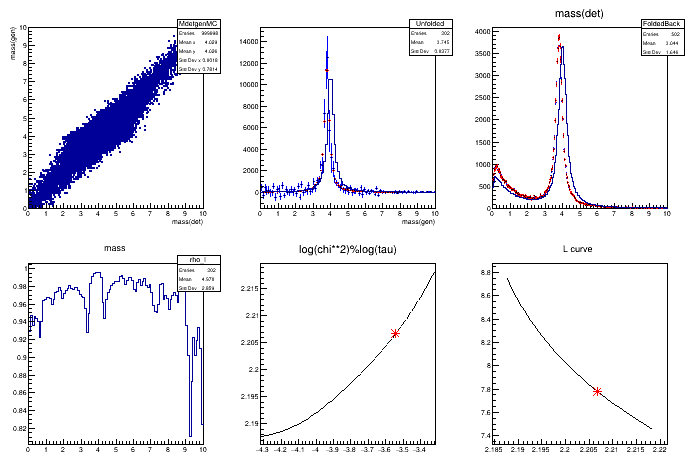

In [5]:
gROOT->GetListOfCanvases()->Draw()